In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.io import imshow
from skimage.io import imread
from torchvision.utils import save_image
import matplotlib.pyplot as plt

import shutil
import os
import cv2
import sys

from sklearn.model_selection import train_test_split

import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch


sys.path.append('../')
from CycleGAN.models import Generator
from CycleGAN.models import Discriminator
from CycleGAN.utils import ReplayBuffer
from CycleGAN.utils import LambdaLR
from CycleGAN.utils import Logger
from CycleGAN.utils import weights_init_normal
from CycleGAN.datasets import ImageDataset

### Делим данные на 2 класса

In [17]:
celeb_attrs = pd.read_csv('../datasets/list_attr_celeba.csv')

In [21]:
celeb_attrs = pd.DataFrame(data[1:], columns=data[0])
train_files_A = celeb_attrs[celeb_attrs.Smiling == '1'].image_id.values
train_files_B = celeb_attrs[celeb_attrs.Smiling != '1'].image_id.values

In [32]:
for file_name in train_files_A[:10]:
    shutil.copy('../datasets/img_align_celeba_50/' + file_name, '../datasets/train_A/' + file_name)
for file_name in train_files_B[:10]:
    shutil.copy('../datasets/img_align_celeba_50/' + file_name, '../datasets/train_B/' + file_name)

Подготовка картинок для обучения: выделение лиц

In [39]:
def crop_faces_and_save(input_path, output_path):
    image_path = input_path

    def save_faces(cascade, imgname):
        img = cv2.imread(os.path.join(image_path, imgname))
        for i, face in enumerate(cascade.detectMultiScale(img)):
            x, y, w, h = face
            sub_face = img[y:y + h, x:x + w]
            cv2.imwrite(os.path.join(output_path, "{}".format(imgname)), sub_face)
            break


    face_cascade = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(face_cascade)
    # Iterate through files
    for i, f in enumerate([f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]):
        save_faces(cascade, f)
        if i > 3000:
            break

In [42]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml -P ./
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P ./
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml -P ./

In [41]:
crop_faces_and_save('../datasets/train_A', '../datasets/crop/train_A')
crop_faces_and_save('../datasets/train_B', '../datasets/crop/train_B')

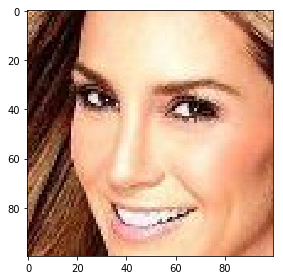

In [50]:
imshow('../datasets/crop/train_A/000001.jpg')

In [61]:
class Parameters():
    def __init__(self):
        self.epoch = 0
        self.n_epochs = 200
        self.batchSize = 1
        self.lr = 0.0002
        self.decay_epoch = 100
        self.size = 256
        self.input_nc = 3
        self.output_nc = 3
        self.cuda = False
        self.n_cpu = 8
        self.dataroot = '../datasets/crop'
        
opt = Parameters()

In [64]:
if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

# Load state dicts
generator_A2B = '../models/netG_A2B-final.pth'
generator_B2A = '../models/netG_B2A-final.pth'
discriminator_A = '../models/netD_A-final.pth'
discriminator_B = '../models/netD_B-final.pth'

netG_A2B.load_state_dict(torch.load(generator_A2B, map_location='cpu'))
netG_B2A.load_state_dict(torch.load(generator_B2A, map_location='cpu'))
netD_A.load_state_dict(torch.load(discriminator_A, map_location='cpu'))
netD_B.load_state_dict(torch.load(discriminator_B, map_location='cpu'))


# netG_A2B.apply(weights_init_normal)
# netG_B2A.apply(weights_init_normal)
# netD_A.apply(weights_init_normal)
# netD_B.apply(weights_init_normal)

if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)

../CycleGAN/utils.py:114: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


['../datasets/crop/train_A/000001.jpg', '../datasets/crop/train_A/000002.jpg', '../datasets/crop/train_A/000009.jpg', '../datasets/crop/train_A/000011.jpg', '../datasets/crop/train_A/000012.jpg', '../datasets/crop/train_A/000013.jpg', '../datasets/crop/train_A/000014.jpg', '../datasets/crop/train_A/000016.jpg', '../datasets/crop/train_A/000017.jpg', '../datasets/crop/train_A/000018.jpg']


In [0]:

###################################

###### Training ######
for epoch in range(80, opt.n_epochs):
    print('epoch = ', epoch)
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        # logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
        #            'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
        #            images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})
        if i % 100 == 0:
            print({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)})

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), './models/netG_A2B-final.pth')
    torch.save(netG_B2A.state_dict(), './models/netG_B2A-final.pth')
    torch.save(netD_A.state_dict(), './models/netD_A-final.pth')
    torch.save(netD_B.state_dict(), './models/netD_B-final.pth')
   

epoch =  80


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


{'loss_G': tensor(3.1565, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_identity': tensor(0.9259, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_GAN': tensor(0.5989, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_cycle': tensor(1.6317, device='cuda:0', grad_fn=<AddBackward0>), 'loss_D': tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)}
{'loss_G': tensor(3.0395, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_identity': tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_GAN': tensor(0.8753, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_cycle': tensor(1.5532, device='cuda:0', grad_fn=<AddBackward0>), 'loss_D': tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)}
{'loss_G': tensor(2.7419, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_identity': tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_GAN': tensor(0.9392, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_cycle': tensor(1.3269, device='cuda:0', grad_fn=<AddBackward0>), 'l

Сохраняем модели.

In [0]:
torch.save(netG_A2B.state_dict(), '/content/drive/My Drive/netG_A2B-%s.pth'%epoch)
torch.save(netG_B2A.state_dict(), '/content/drive/My Drive/netG_B2A-%s.pth'%epoch)
torch.save(netD_A.state_dict(), '/content/drive/My Drive/netD_A-%s.pth'%epoch)
torch.save(netD_B.state_dict(), '/content/drive/My Drive/netD_B-%s.pth'%epoch)

In [0]:
# An example input you would normally provide to your model's forward() method.
example = torch.rand(1, 3, 256, 256).cuda()

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(netG_A2B, example)
traced_script_module.save("./models/netG_smile2sad.pt")
traced_script_module = torch.jit.trace(netG_B2A, example)
traced_script_module.save("./models/netG_sad2smile.pt")